# Project: Filling-In Missing Reviews

## The Simulation

Below we simulate three $X$ (feature columns):

* arrival delay, $30 \pm 15$ (minutes)
* package size, `"S", "M", "L"`
* depot distance, $2.5 \pm 0.5$ km

In [85]:
import numpy as np

In [215]:
N = 1000

In [216]:
# X
arrival_delay  = np.random.normal(30, 15, size=N) 
package_size   = np.random.choice(["S", "M", "L"], p=(0.85, 0.10, 0.05), size=N)
depot_distance = np.random.normal(2.5, 0.5, size=N) + 1

From these we simulate a rating, we ask:

* which arrival delays are below 15min?
    * if so, you get +10, if not +4
* which packages are small/medium and arrive within 30min?
    * if so, you get +10, if not +4
* which customers are far from the depot and whose package arrive within 30min?
    * if so, you get +9, if not + 4
* and let's add in some random effects
    * add in $0 \pm 2$
    
* we scale this total to go between $0 - 10$
    * `10 * rating/max`

In [217]:
# pieces of y
on_time    = (arrival_delay < 15)
small_time = ((package_size == "S") | (package_size == "M")) & (arrival_delay < 30)
tolerant   = (depot_distance > 4) & (arrival_delay < 30)
effects    = np.random.normal(0, 2, size=N)

In [218]:
# y
rating = (on_time * 6 + 4) + (small_time * 6 + 4) + (tolerant * 5 + 4) + 2 + effects
rating = (10 * rating/rating.max())

In [219]:
# Summary
rating.mean(), rating.std(), rating.max(), rating.min()

(5.083495080441796, 1.4702881150722316, 10.0, 2.4095727229627166)

----

## Into a Table

In [220]:
import pandas as pd

In [221]:
review = pd.DataFrame({
    "Delay": arrival_delay.round(),
    "Size": package_size,
    "Distance": depot_distance.round(1),
    "Rating": rating.round(1)
})

In [222]:
review.sample(3)

,Delay,Size,Distance,Rating
86,14.0,S,3.5,7.0
226,41.0,L,2.5,4.6
93,23.0,S,3.3,5.9


#### Simulating Missing Data

Below we obtain the indexes of a $70\%$ sample taken at random, and set their `Rating` column to `None`, ie., missing....

In [223]:
missing_index = review['Rating'].sample(frac=0.7).index

review.loc[missing_index, 'Rating'] = None

So now we have the final, simulated, dataset,

In [224]:
review.sample(5)

,Delay,Size,Distance,Rating
475,45.0,S,4.1,NaN
74,14.0,S,3.9,NaN
277,3.0,S,3.9,NaN
76,18.0,S,4.3,NaN
825,4.0,S,3.6,NaN


----

## <font color=purple> The Project </font>

#### Part 0: Clean the `review` dataset
* Define a new variable `clean` which is the `review` dataset without missing data
    * HINT: `.dropna`
    * see the pandas notes, which discuss removing missing data
    
#### Part 1: Build a Linear Regression Model of the `Rating`
* Choose `X` to be the `Delay` and `Distance` columns in the `clean` dataset
* Choose `y` to be the `Rating` column
* Import `LinearRegression`
    * `.fit`, `.predict` 
* Score on the same dataset for now

#### Part 2: Predict the reveiws which we don't know
* Find the `Delay` and `Distance` parts of the rows with a missing `Rating`
    * HINT: `review.loc[ review['Rating'].isnull(),   ['Delay', 'Distance']]`
    * NOTE: this uses `review`, not `clean` because `clean` doesnt have missing data
* Put this data into your `.predict` and therefore obtain the missing ratings
* EXTRA (harder):
    * Glue the missing ratings onto the delays and distances
    * HINT: use `pd.DataFrame` to create 
        * `Delay`, `Distance` from your missing, `Rating` from your predictions
        * use `pd.concat` with your `clean` data, ignoring the `Size` column
            * HINT: `clean.drop(columns=['Size'])`
    
    
#### Step 3: Obtain a cross-validated score for various models
* Import `cross_val_score` and obtain a score for:
    * `LinearRegression`  (from sklearn.linear_model import...)
    * `DecisionTreeRegressor` (from sklearn.tree import ...)
    * `KNearestRegressor` (from sklearn.neighbors import ...)
    * HINT: `cross_val_score(KNearestRegressor(), clean[...], clean[...]).mean()`
* Which approach produces the best score?

    
## EXTRA

#### Part 4: Include `size` in your `.fit`

* Import the `OrdinalEncoder`
* `.fit` and then `.transform` the `size` column (into numbers)
* Use the transformed column with your `.fit` and `.predict`
    * HINT: `X_delay`, `X_distance`, `X_size_enc` 
    * HINT: `X = np.c_[X_delay, X_distance, X_size_enc]`

Solution template,

In [246]:
# clean the data

# choose X, choose y from clean data

# import linear reg

# fit

# find the original rows which have missing ratings

# predict for those rows

# use cross_val_score to compare approaches

# EXTRA: include the size column, and repeat the above

## The Solution (10 to 20 lines)

In [225]:
review.sample()

,Delay,Size,Distance,Rating
531,-2.0,S,3.8,7.3


In [226]:
clean = review.dropna()

In [227]:
X = clean[['Delay', 'Distance']]
y = clean['Rating']

In [228]:
from sklearn.linear_model import LinearRegression

In [229]:
lr = LinearRegression().fit(X, y)

In [230]:
missing = review.loc[ review['Rating'].isnull(),   ['Delay', 'Distance']]

In [231]:
yhat_missing = lr.predict(missing)

---

In [232]:
%matplotlib inline
import seaborn as sns

plot_sample = clean.sample(50)

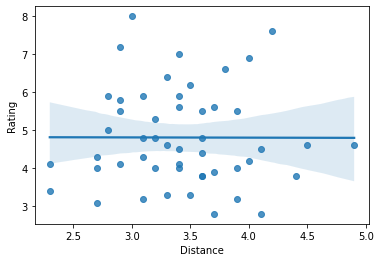

In [233]:
sns.regplot(x=plot_sample['Distance'], y=plot_sample['Rating']);

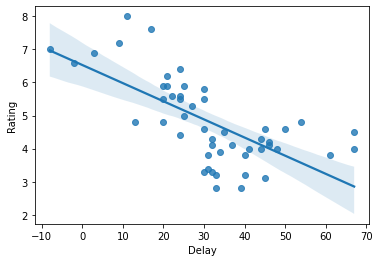

In [234]:
sns.regplot(x=plot_sample['Delay'], y=plot_sample['Rating']);

---

#### EXTRA: Merging the Datasets

In [235]:
partial = pd.DataFrame({
    'Delay': missing['Delay'],
    'Distance': missing['Distance'],
    'Rating': yhat_missing
})

In [236]:
complete = pd.concat([partial, clean.drop(columns=['Size'])])

In [237]:
complete.sample()

,Delay,Distance,Rating
736,31.0,4.2,4.5


----

In [238]:
from sklearn.model_selection import cross_val_score

In [239]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [240]:
print(cross_val_score(LinearRegression(), X, y).mean())
print(cross_val_score(DecisionTreeRegressor(), X, y).mean())
print(cross_val_score(KNeighborsRegressor(), X, y).mean())

0.5532126446931637
0.5030025274453859
0.6621415609765496


In [241]:
for k in range(2, 8):
    print(k, cross_val_score(KNeighborsRegressor(k), X, y).mean())

2 0.6251785353942365
3 0.6430546358151873
4 0.662992579204082
5 0.6621415609765496
6 0.6798422525637612
7 0.6951722668263253


---

### EXTRA: Retraining with the best Model

Above, we determined that `KNN` with `k=3` was the most accurate model, therefore we retrain using this,

In [242]:
model = KNeighborsRegressor(3).fit(X, y)
yhat_better = model.predict(missing).round(1)

In [243]:
completed = pd.concat([clean.drop(columns=['Size']),   pd.DataFrame({
    'Delay': missing['Delay'],
    'Distance': missing['Distance'],
    'Rating': yhat_better
})])

In [244]:
complete.describe()

,Delay,Distance,Rating
count,1000.00000,1000.000000,1000.000000
mean,30.17500,3.524100,5.064464
std,14.75914,0.486113,1.193065
min,-21.00000,1.800000,1.608141
25%,20.00000,3.200000,4.174440
50%,31.00000,3.500000,5.000000
75%,41.00000,3.900000,5.835569
max,77.00000,5.000000,10.000000


In [245]:
completed.describe()

,Delay,Distance,Rating
count,1000.00000,1000.000000,1000.000000
mean,30.17500,3.524100,5.086500
std,14.75914,0.486113,1.350315
min,-21.00000,1.800000,2.500000
25%,20.00000,3.200000,4.000000
50%,31.00000,3.500000,4.750000
75%,41.00000,3.900000,6.000000
max,77.00000,5.000000,10.000000


### EXTRA: Size

In [247]:
from sklearn.preprocessing import OrdinalEncoder

In [287]:
# starting with the review dataset we obtain a cleaned version: ie., no missing data
clean = review.dropna()


# we choose X, y
X_numeric = clean[['Delay', 'Distance']]
y = clean['Rating']

# the non-numeric X: transform
enc = OrdinalEncoder().fit(clean[['Size']])
X_size = enc.transform(clean[['Size']]) # numbers for the non-numeric

# the total X combining both numeric and transformed
X = np.c_[X_numeric, X_size]



#### CHOOOSE A BETTER MODEL: (aside: use cross_val_score on different approaches)

# we train X,y

model = KNeighborsRegressor(3).fit(X, y)

# predict for the missing data: we have to transform the Size col in the original
missing = review.loc[ review['Rating'].isnull(),   ['Delay', 'Distance', 'Size']]

#### // CHOOSE A BETTER MODEL: replace with better model


# the Xs for which we don't know their y
X_unknown = np.c_[
    missing[['Delay', 'Distance']], 
    enc.transform(missing[['Size']])
]

# we have the unknown ratings
yhat  = full_model.predict(X_unknown).round(1)


# glue the clean dataset (has no missing), with the missing + predictions
completed = pd.concat([
    clean,
    pd.DataFrame({
        'Delay': missing['Delay'],
        'Distance': missing['Distance'],
        'Size': missing['Size'],
        'Rating': yhat,
    })
])


completed['Rating'].mean().round()

5.0

* refer to ML notebooks, Pandas, ...